<a href="https://colab.research.google.com/github/der41/XAI_Duke/blob/main/Notebooks/Machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





In [ ]:
from typing_extensions import dataclass_transform
import os

# Remove Colab default sample_data
!rm -r ./sample_data ./XAI_Duke

# Clone GitHub files to colab workspace
repo_name = "XAI_Duke"
git_path = 'https://github.com/der41/XAI_Duke.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

rm: cannot remove './XAI_Duke': No such file or directory
Cloning into 'XAI_Duke'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 51 (delta 16), reused 11 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 1.64 MiB | 5.90 MiB/s, done.
Resolving deltas: 100% (16/16), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b50738d6736fbcfe7a0596a34eca94738710017a6c4864e808ecb631f566a7c9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
  Created wheel for anchor-exp

## 🩺 Case: Tumor Misclassification – Breast Cancer Dataset
#### 🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

#### 🟥 Prosecution
Use explanation tools to evaluate how the model arrived at this decision. Consider whether any key medical indicators might have been overlooked or minimized.



In [ ]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#XAI libraries
import shap
from lime import lime_tabular
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay


# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


An initial diagnostic to note is that the model’s recall is lower for malignant cases (93%) than for benign cases (99%). Ideally, we would reverse this priority: it is more dangerous to classify a malignant case as benign than to classify a benign case as malignant.

### SHAP Plot — Global Explainability

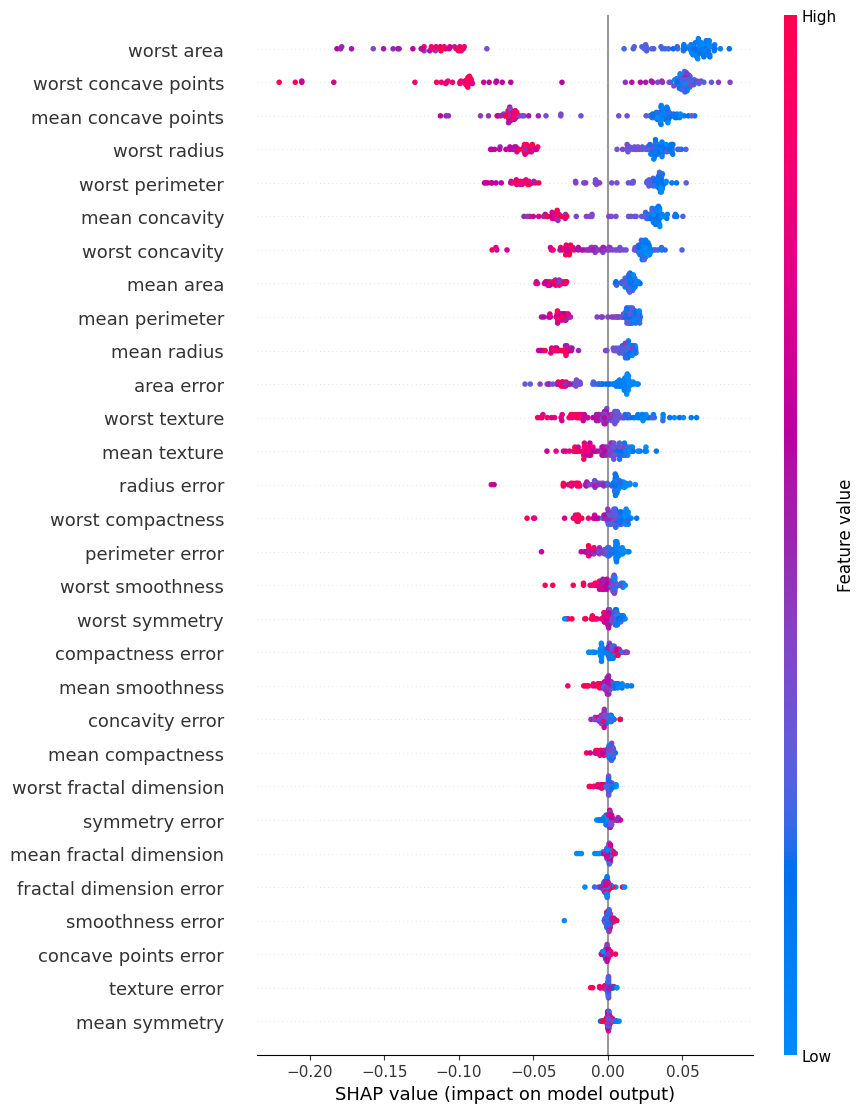

In [ ]:
# ---------------------------------
# 1) SHAP — local & global views
# ---------------------------------
pred = model_bc.predict(X_test)

# New-style SHAP API
explainer = shap.TreeExplainer(model_bc)
explanation = explainer(X_test)  # multi-output for classification

# Pick the positive class (benign = 1 in this dataset)
pos_idx = list(model_bc.classes_).index(1)  # Picking the Benign prediction

# Slice the Explanation to a single output (class) BEFORE plotting
explanation_pos = explanation[:, :, pos_idx]   # (n_samples, n_features) view

# Beeswarm
shap.plots.beeswarm(explanation_pos, max_display =30)




From the SHAP values we see that the model relies heavily on a subset of features—especially worst area, worst concave points, mean concave points, worst radius, and worst perimeter. In addition, worst texture shows a broad, dispersed effect across its range, making it influential in determining benign vs. malignant. This implies that if a patient has an extremely low value on one of these key features, the model may classify the case as benign even when many of the other 23 variables point toward malignancy.

### LIME — Local Explainability

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



LIME explanation (top 10 features):
worst texture <= 21.05: +0.0594
mean texture <= 16.17: +0.0305
0.25 < worst symmetry <= 0.28: +0.0202
0.10 < worst concave points <= 0.16: +0.0202
worst compactness > 0.34: -0.0190
0.23 < worst concavity <= 0.39: -0.0184
0.32 < radius error <= 0.47: +0.0182
0.06 < mean concavity <= 0.13: -0.0154
24.72 < area error <= 43.73: +0.0151
worst fractal dimension > 0.09: -0.0129
0.02 < concavity error <= 0.03: -0.0125
fractal dimension error > 0.00: +0.0113
85.98 < mean perimeter <= 103.75: -0.0101
0.02 < compactness error <= 0.03: +0.0083
0.03 < mean concave points <= 0.07: -0.0082
551.70 < mean area <= 767.60: +0.0078
0.01 < concave points error <= 0.01: +0.0077
97.67 < worst perimeter <= 124.65: -0.0074
0.16 < mean symmetry <= 0.18: +0.0071
686.60 < worst area <= 1031.50: -0.0064
0.13 < worst smoothness <= 0.15: -0.0064
14.97 < worst radius <= 18.41: -0.0062
0.09 < mean smoothness <= 0.10: -0.0043
2.29 < perimeter error <= 3.27: -0.0040
0.06 < mean fract

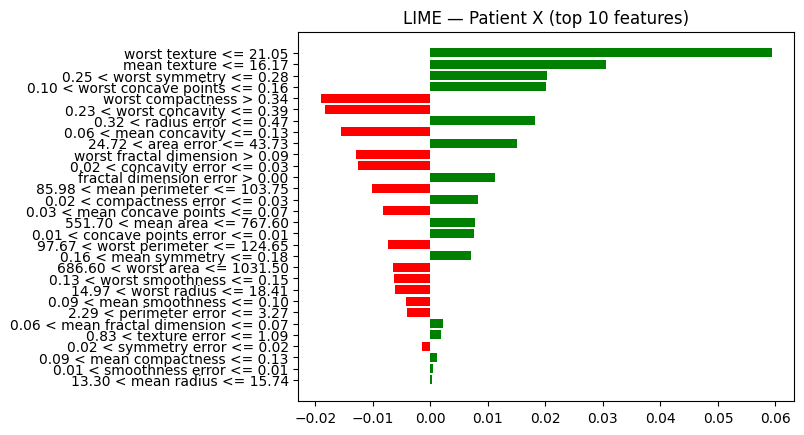

In [ ]:
from itertools import accumulate
# ---------------------------------
# 2) LIME — local explanation
# ---------------------------------
# LIME expects numpy arrays; provide training data to build the local surrogate
class_names = ["malignant", "benign"]  # align with 0/1 coding
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,       # classic tabular LIME behavior
    random_state=42
)

lime_exp = lime_explainer.explain_instance(
    data_row=focus_instance_bc.values[0],
    predict_fn=model_bc.predict_proba,
    num_features=30
)

print("\nLIME explanation (top 10 features):")
total = 0
name = []
accumulated_weight = []
for feat, weight in lime_exp.as_list():
    print(f"{feat}: {weight:+.4f}")
    total += weight
    name.append(feat)
    accumulated_weight.append(total)

# LIME visualization
fig = lime_exp.as_pyplot_figure()
plt.title("LIME — Patient X (top 10 features)")
plt.show()

#plot


The LIME explanation for Patient X supports this story: worst texture and worst concave points appear among the most important features driving the benign label. However, Patient X also shows several malignancy-leaning contributions that would warrant a biopsy.

### ICE — Patient X, Benign-Leaning Contributions

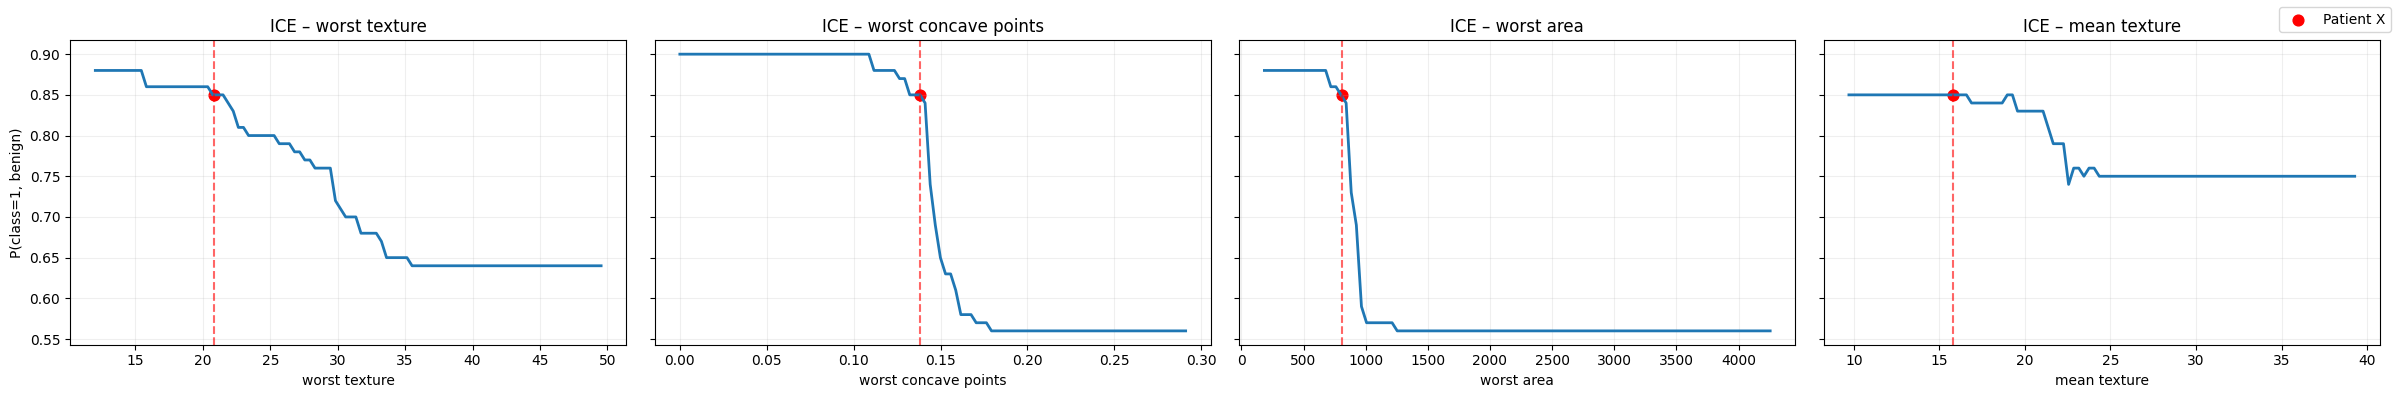

In [ ]:
# ---------------------------------
# 3.1) ICE — Patient X Benign Contributions
# ---------------------------------
def ice_row(features, X, model, focus_instance, class_idx=1, n=100):
    """Draw a single row of ICE plots (one axis per feature)."""
    # Resolve to names
    feat_names = [X.columns[f] if isinstance(f, int) else f for f in features]

    fig, axes = plt.subplots(
        nrows=1, ncols=len(feat_names),
        figsize=(6*len(feat_names), 4),  # wider, single row
        sharey=True
    )

    if len(feat_names) == 1:
        axes = [axes]  # make iterable

    base = focus_instance.iloc[[0]].copy()

    for ax, feat_name in zip(axes, feat_names):
        # Grid over observed range
        fmin, fmax = X[feat_name].min(), X[feat_name].max()
        grid = np.linspace(fmin, fmax, n)

        # Predictions across the grid
        preds = np.empty_like(grid, dtype=float)
        for i, val in enumerate(grid):
            inst = base.copy()
            inst[feat_name] = val
            preds[i] = model.predict_proba(inst)[:, class_idx].item()

        # Patient X actual point
        x_real = float(base[feat_name].iloc[0])
        y_real = float(model.predict_proba(base)[:, class_idx][0])

        # Plot
        ax.plot(grid, preds, lw=2)
        ax.scatter([x_real], [y_real], s=60, c='red', label='Patient X')
        ax.axvline(x_real, color='red', linestyle='--', alpha=0.6)
        ax.set_xlabel(feat_name)
        ax.set_title(f'ICE – {feat_name}')
        ax.grid(alpha=0.2)

    axes[0].set_ylabel('P(class=1, benign)')
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    plt.show()

# Pick exactly three features (by index or name)
features_to_plot = ["worst texture", "worst concave points", "worst area", "mean texture"]
ice_row(features_to_plot, X, model_bc, focus_instance_bc, class_idx=1, n=100)



When we analyze the ICE plots for features that favor a benign decision, at least two of them (worst concave points and worst area) are at levels closely linked to a sharp decrease in the probability of being categorized as benign. A model tuned for higher sensitivity (minimizing false negatives) would likely shift this boundary, lowering tolerance for such values.

### Partial Dependence — Patient X, Benign-Leaning Contributions

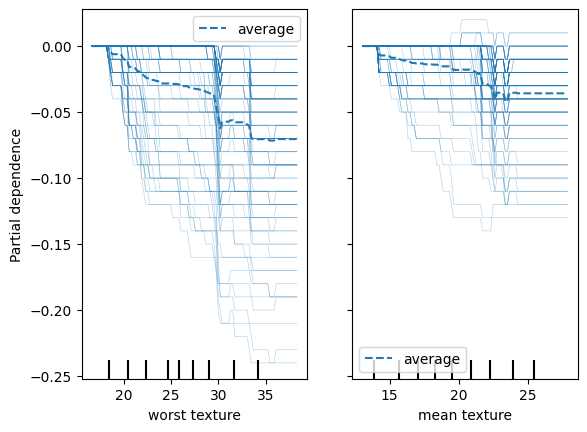

In [ ]:
# ---------------------------------
# 3.2) Partial Dependency — Patient X Benign Contributions
# ---------------------------------
features = ["worst texture", "mean texture"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model_bc, X_test, features, kind='both', centered=True)

For worst texture and mean texture, we observe substantial heterogeneity in predicted probabilities. This suggests that—even if their average effect on malignancy is modest at different levels—interactions with other variables make it difficult to determine a stable range of benign probabilities for Patient X.

### Patient X — ICE, Malignant-Leaning Contributions

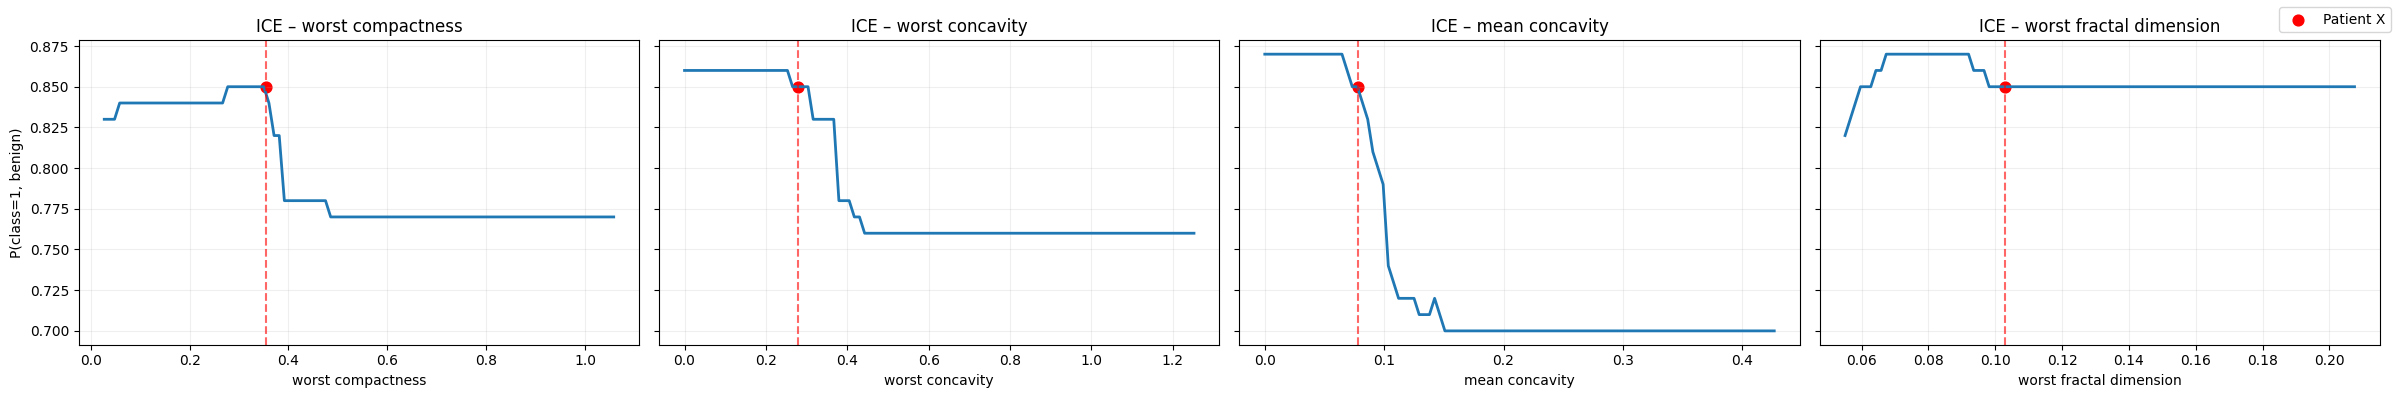

In [ ]:
features_to_plot = ["worst compactness", "worst concavity", "mean concavity", "worst fractal dimension"]
ice_row(features_to_plot, X, model_bc, focus_instance_bc, class_idx=1, n=100)

Similarly, the ICE analysis for worst concavity, worst compactness, and mean concavity places Patient X near values that further reduce the probability of a benign diagnosis—strengthening the case for recommending a biopsy.

### Patient X — Partial Dependence, Malignant-Leaning Contributions

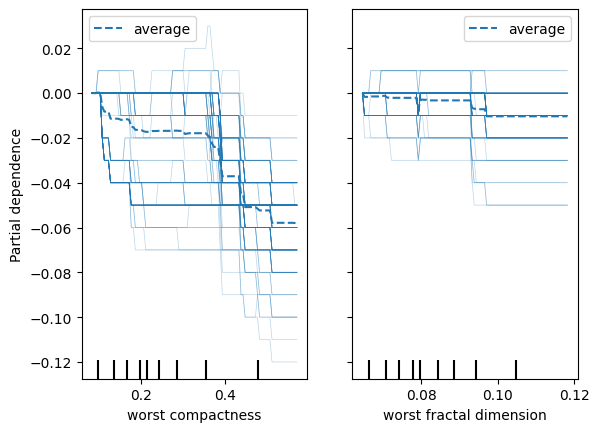

In [ ]:
# Choose the feature of interest
features = ["worst compactness", "worst fractal dimension"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model_bc, X_test, features, kind='both', centered=True)

Partial dependence plots for features that contribute less, on average, to malignancy still show high variability. This indicates that, even among these weaker contributors, Patient X’s assigned probability could meaningfully change depending on the values of other interacting features.

### Overall recommendations

This model shows many features that suggest than improvement should be made to avoid the case of Patient X in the future.

- First, the model show a lower recall value for malignant cases than for benign cases. This is something that you want to avoid when you are dealing with something as important as human life. Even at the expense of lowe overall accuaracy of the model.

- Second, the SHAP plot suggests the model overuses a subset of features, underweighting signals from roughly two-thirds of the available variables

- Third, the LIME indicates many features contribute toward a malignant decision but are being underweighted relative to a few benign-leaning cues. ICE and partial dependence show Patient X’s values sit near thresholds where small changes would markedly increase the predicted malignancy probability.

